In [1]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16) 

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [2]:
import re
import hashlib
import os
import torch
from huggingface_hub import snapshot_download
from PIL import Image

from moondream_model import VisionEncoder, TextModel

model_path = snapshot_download("vikhyatk/moondream1")

DEVICE = "cuda"
DTYPE = torch.float16

vision_encoder = VisionEncoder(model_path).to(DEVICE, dtype=DTYPE)
text_model = TextModel(model_path).to(DEVICE, dtype=DTYPE)

print(f"Using:{DEVICE}")
print(f"Type: {DTYPE}")

def cached_vision_encoder(image):
    image_hash = hashlib.sha256(image.tobytes()).hexdigest()
    cache_path = f"image_encoder_cache/{image_hash}.pt"
    if os.path.exists(cache_path):
        return torch.load(cache_path).to(DEVICE, dtype=DTYPE)
    else:
        image_vec = vision_encoder(image).to("cpu", dtype=torch.float16)
        os.makedirs("image_encoder_cache", exist_ok=True)
        torch.save(image_vec, cache_path)
        return image_vec.to(DEVICE, dtype=DTYPE)

def answer_question(image, question):

    with torch.inference_mode():
        image_embeds = cached_vision_encoder(image)
        result = text_model.answer_question(image_embeds, question)

    # Check if the result is a tuple and extract the text part
    if isinstance(result, tuple):
        result_text = result[0]
    else:
        result_text = result

    # Convert the result to string if it's not already
    if not isinstance(result_text, str):
        if torch.is_tensor(result_text):
            result_text = result_text.cpu().numpy().tolist()
            result_text = ' '.join(map(str, result_text))
        else:
            result_text = str(result_text)

    # Apply regex to clean up the result string
    cleaned_result = re.sub("<$", "", re.sub("END$", "", result_text))
    return cleaned_result



def moondream(img, prompt):
    result = answer_question(img, prompt)
    return result


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Using:cuda
Type: torch.float16


Generate method took 0.3736438751220703 seconds.
Generate method took 0.849949836730957 seconds.
Generate method took 0.3371851444244385 seconds.
Generate method took 0.6316900253295898 seconds.
Generate method took 0.3019077777862549 seconds.
Generate method took 0.298677921295166 seconds.
Generate method took 0.629342794418335 seconds.
Generate method took 0.37404680252075195 seconds.
Generate method took 0.9719886779785156 seconds.
Generate method took 0.44303297996520996 seconds.


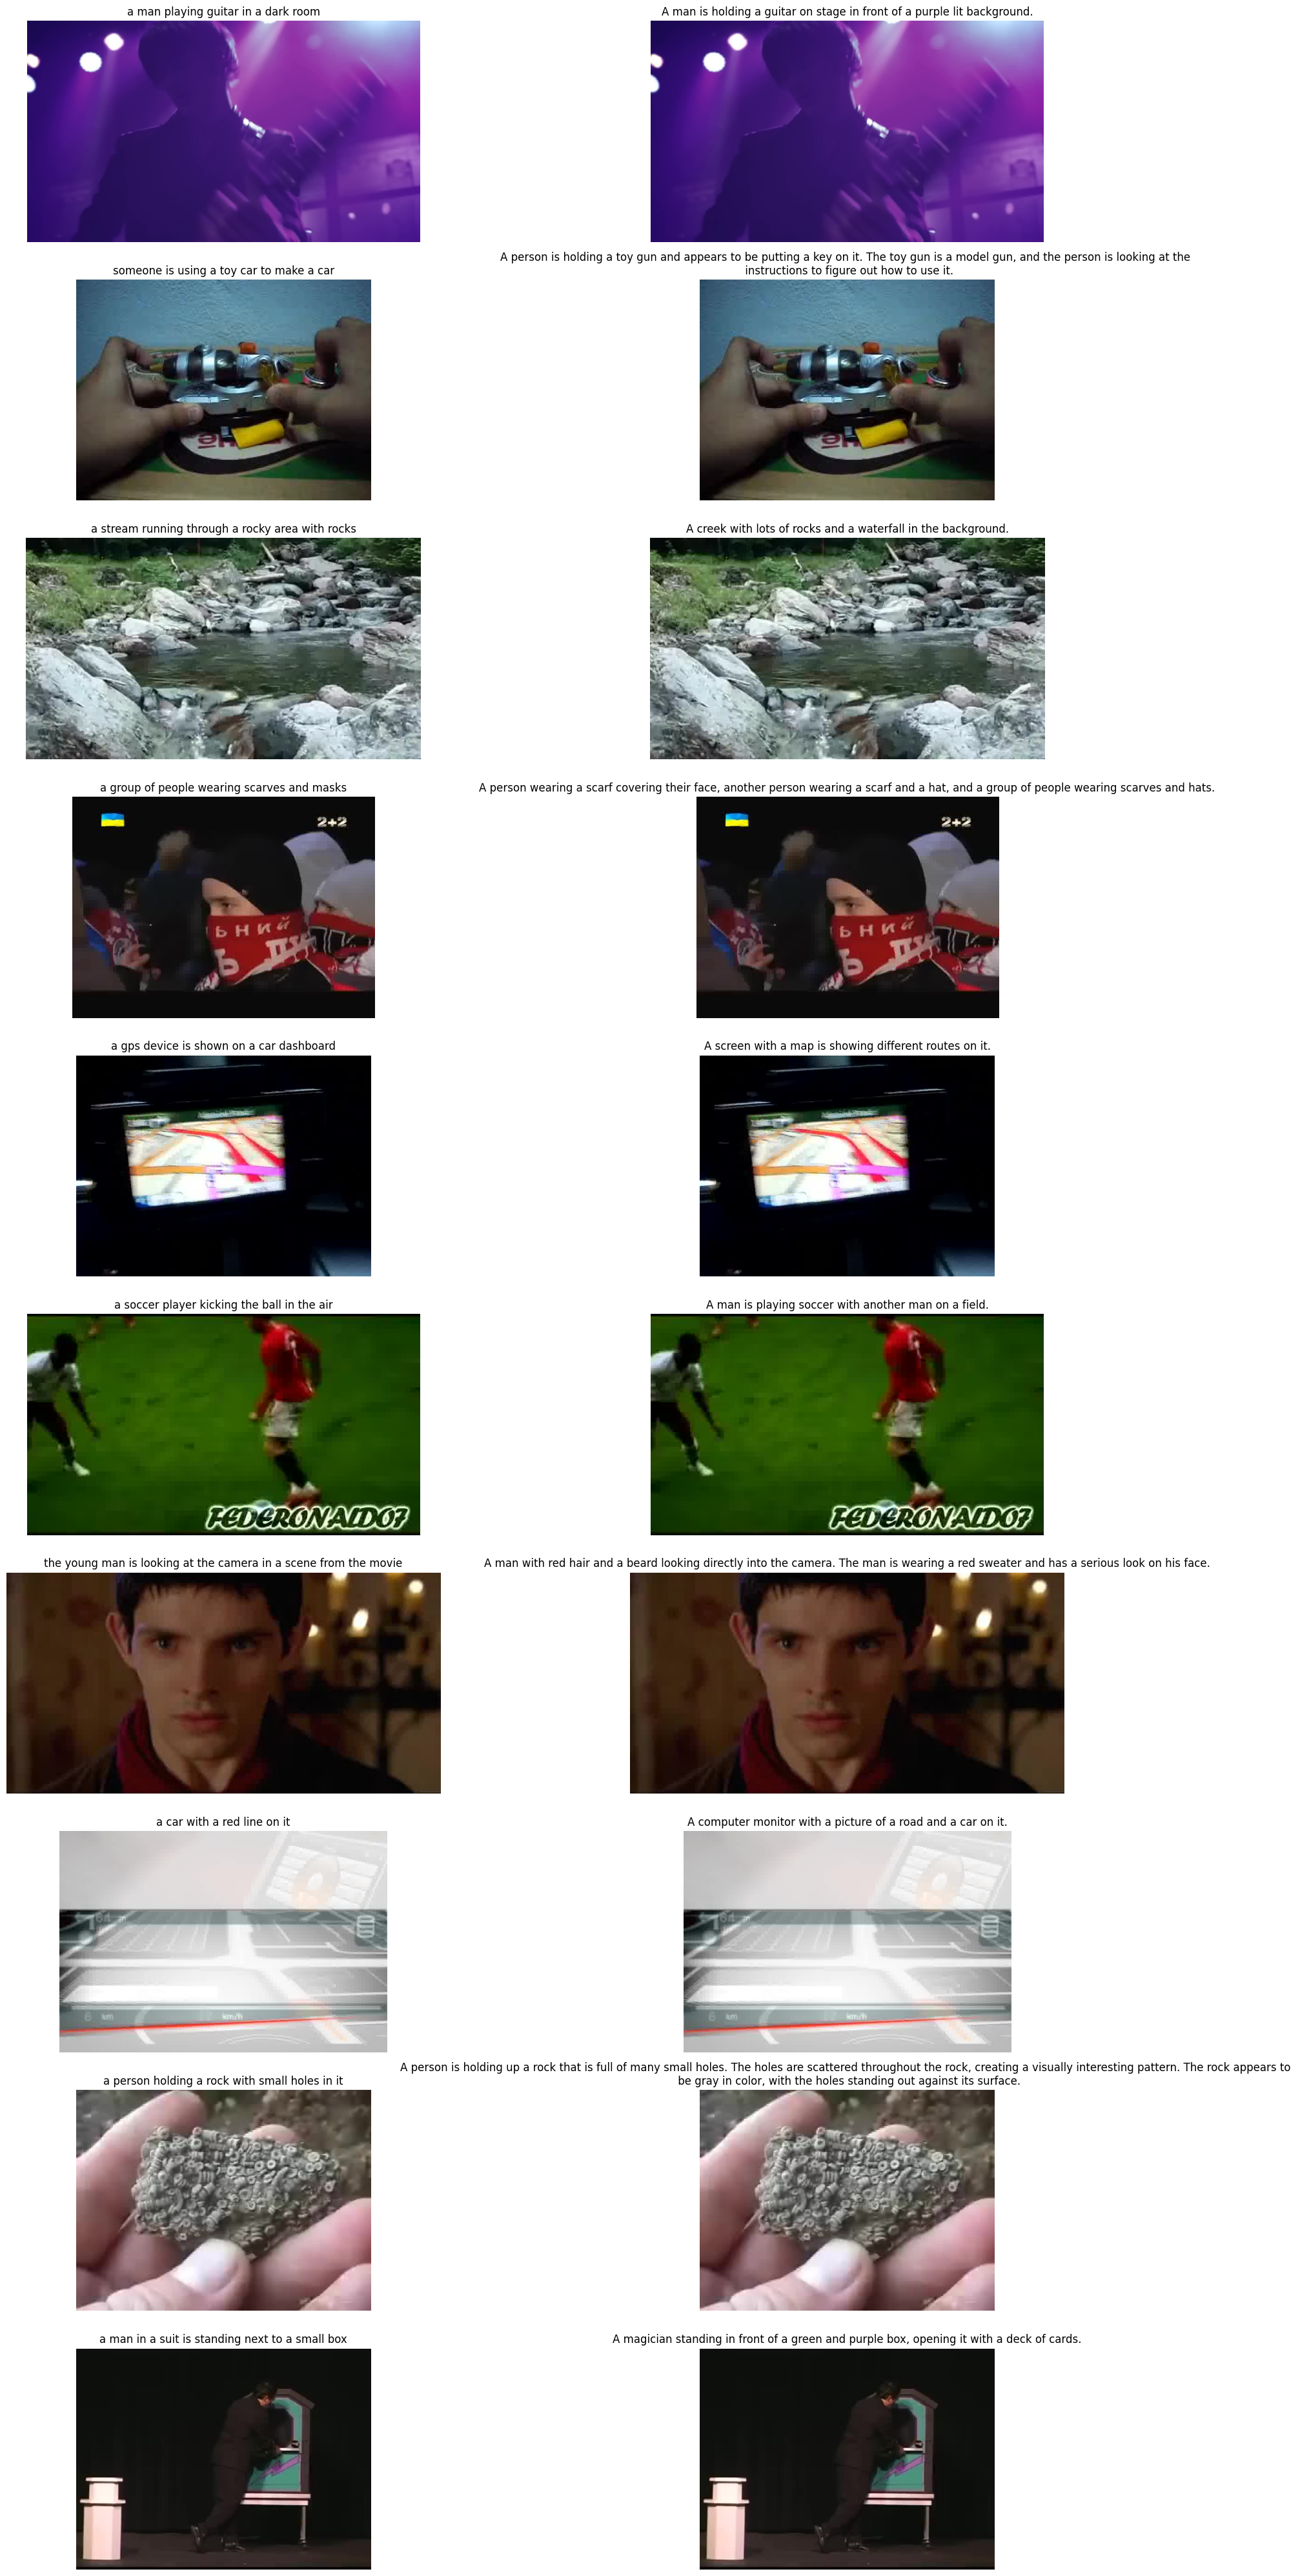

In [4]:
# Define the folder path
folder_path = '/home/dnth/Desktop/datasets/15KVid_newcaptions/dataset'

# Collect image file paths from subdirectories
image_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(folder_path) 
               for f in filenames if f.endswith(('jpg', 'jpeg', 'JPG'))]

# Randomly select a subset of images
random.shuffle(image_files)
selected_images = image_files[:10]

# Define prompts
# prompt1 = "a picture of"
# prompt2 = "Question: Describe what do you see in this image? Answer:"

# Set up plotting parameters
num_images = len(selected_images)
# 3 subplots per image: no prompt, prompt1, prompt2
num_columns = 3
num_rows = num_images
plt.figure(figsize=(30, num_images * 4)) # Adjusted figure size for clarity

# Process and display each image
for i, img_path in enumerate(selected_images):
    img = Image.open(img_path)

    inputs = processor(img, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=20)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    # Display image with no prompt
    plt.subplot(num_rows, num_columns, i * num_columns + 1)
    plt.imshow(img)
    plt.title(generated_text)
    plt.axis('off')

    # Display image with prompt1

    # prompt = "Caption the images in flickr style."
    prompt = "Produce a dense caption of every object in the image."
    generated_text1 = moondream(img, prompt)

    words = generated_text1.split()
    
    if len(words) > 60:
        # Insert a line break after the 60th and 30th words
        words.insert(60, "\n")
        words.insert(30, "\n")
    elif len(words) > 30:
        # Insert a line break after the 30th word
        words.insert(30, "\n")

    # Join the words back into a string
    modified_title = ' '.join(words)

    plt.subplot(num_rows, num_columns, i * num_columns + 2)
    plt.imshow(img)
    plt.title(modified_title)
    plt.axis('off')

    # Display image with prompt2
    # inputs2 = processor(img, text=prompt2, return_tensors="pt").to(device, torch.float16)
    # generated_ids2 = model.generate(**inputs, max_new_tokens=50, min_length=15, repetition_penalty=1.4)
    # generated_text2 = processor.batch_decode(generated_ids2, skip_special_tokens=True)[0].strip()

    # plt.subplot(num_rows, num_columns, i * num_columns + 3)
    # plt.imshow(img)
    # plt.title(generated_text2)
    # plt.axis('off')

plt.tight_layout()
plt.show()
